# Neural Network Committee

In [1]:
# Add imports
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from operator import add 
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import random

# Setup
sns.set()

# Hyperparameters
num_epochs = 35
num_classes = 10
batch_size = 500
learning_rate = 0.01
result_folder='data/results/'
weight_decay = 1e-4
grad_clip = 0.1
image_width=32
image_height=32

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [3]:
device = get_default_device()
device

device(type='cuda')

In [4]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
trainTfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
testTfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

data_dir = './data/cifar10'

train_dataset = ImageFolder(data_dir+'/train', trainTfms)
test_ds = ImageFolder(data_dir+'/test', testTfms)

validation_size = int(0.6 * len(test_ds))
test_size = len(test_ds) - validation_size

In [5]:
def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

# Define network
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                            nn.Flatten(),
                                            nn.Dropout(0.2),
                                            nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [6]:
scale_transform = transforms.Compose([
    transforms.Resize((image_width, image_height)),
    #transforms.RandomCrop((image_width-1, image_height-1)),
    transforms.ToTensor()
])

In [7]:
%%time
acc_cv_list=[[],[],[],[],[]]
loss_cv_list=[[],[],[],[],[]]
tst_acc_cv_list=[[],[],[],[],[]]
tst_loss_cv_list=[[],[],[],[],[]]
lrs_cv_list=[[],[],[],[],[]]
tst_predicted_labels_epoch_cv = [[],[],[],[],[]]
for cv_iter in range(5):
    torch.cuda.empty_cache()
    print(f'\nSubtest {cv_iter}:')

    validation_dataset, test_dataset = torch.utils.data.random_split(
        test_ds,
        [validation_size, test_size]
    )

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(validation_dataset, batch_size*2, num_workers=2, pin_memory=True)

    train_loader = DeviceDataLoader(train_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)

    net = Net(3,10)
    model = to_device(net, device)

    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)

    # Train the network
    loss_list = []
    acc_list = []
    tst_acc_list = []
    tst_loss_list = []
    tst_predicted_labels_epoch = []
    tst_predicted_labels = []
    tst_correct_labels = [] 

    tst_predicted_labels_2 = []
    tst_labels_3 = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        loss = 0.0
        corrects = 0.0
        tst_loss = 0.0
        tst_corrects = 0.0   
        running_loss=0.0
        tst_running_loss=0.0 
        total_trn = 0 #suma sklasyfikowanych ob. trn
        total_tst = 0 #suma sklasyfikowanych ob. tst
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            data = to_device(net, device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss+=loss.item()

            
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
        
            total_trn += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            corrects += (predicted == labels).sum().item()

        else:
            with torch.no_grad():
                for tst_images, tst_labels in test_loader:
                    tst_outputs = model(tst_images)
                    tst_loss = criterion(tst_outputs, tst_labels)
                    tst_running_loss+=tst_loss.item()
                    _, tst_predicted = torch.max(tst_outputs.data, 1)
                    total_tst += tst_labels.size(0)
                    tst_corrects += (tst_predicted == tst_labels).sum().item()
                    
                    ######################################################################################

                    tst_predicted_labels = tst_predicted.cpu().numpy()
                    tst_predicted_labels = tst_predicted_labels.reshape(tst_predicted_labels.shape[0], 1)

                    tst_labels_2 = tst_labels.cpu().numpy()
                    tst_labels_2 = tst_labels_2.reshape(tst_labels_2.shape[0], 1)

                    tst_predicted_labels = np.concatenate((tst_predicted_labels, tst_labels_2), axis=1)

                    
        acc_list.append(corrects / total_trn)
        tst_acc_list.append(tst_corrects / total_tst)        

        epoch_loss = running_loss/len(train_loader)
        loss_list.append(epoch_loss)
        tst_epoch_loss = tst_running_loss/len(test_loader)
        tst_loss_list.append(tst_epoch_loss)

        tst_predicted_labels_epoch.append(tst_predicted_labels)
        

        print('Epoch {}:\ntraining loss: {:.4f}, training accuracy: {:.2f}%'.format(epoch, epoch_loss,(corrects / total_trn) * 100))
        print('validation loss: {:.4f}, validation accuracy: {:.2f}%'.format(tst_epoch_loss,(tst_corrects / total_tst) * 100))
        

    tst_predicted_labels_epoch_cv[cv_iter] = tst_predicted_labels_epoch
    acc_cv_list[cv_iter]=acc_list
    loss_cv_list[cv_iter]=loss_list
    tst_acc_cv_list[cv_iter]=tst_acc_list
    tst_loss_cv_list[cv_iter]=tst_loss_list

print('Finished Training')

    #temp_acc1=acc_list
    #temp_loss1=loss_list
    #temp_tst_acc1=tst_acc_list
    #temp_tst_loss1=tst_loss_list


Subtest 0:
Epoch 0:
training loss: 2.4596, training accuracy: 21.88%
validation loss: 1.8457, validation accuracy: 35.77%
Epoch 1:
training loss: 1.7750, training accuracy: 39.20%
validation loss: 1.4250, validation accuracy: 50.98%
Epoch 2:
training loss: 1.3820, training accuracy: 52.55%
validation loss: 1.1309, validation accuracy: 59.95%
Epoch 3:
training loss: 1.0651, training accuracy: 63.20%
validation loss: 0.9452, validation accuracy: 67.48%
Epoch 4:
training loss: 0.8539, training accuracy: 70.34%
validation loss: 0.8480, validation accuracy: 70.28%
Epoch 5:
training loss: 0.7339, training accuracy: 74.45%
validation loss: 0.6511, validation accuracy: 77.37%
Epoch 6:
training loss: 0.6445, training accuracy: 77.95%
validation loss: 0.6279, validation accuracy: 78.65%
Epoch 7:
training loss: 0.5853, training accuracy: 79.92%
validation loss: 0.5705, validation accuracy: 80.92%
Epoch 8:
training loss: 0.5500, training accuracy: 81.19%
validation loss: 0.5199, validation accura

In [8]:
""" #find the most common value for column in data frame
def most_common(df):
    return df['predicted label'].value_counts().idxmax()
    #return df.mode().iloc[0].astype(int)
    #print(f"The most common predicted labels: {df['predicted label'].value_counts().idxmax()}")
    # print(f"The most common labels: {df['label'].value_counts().idxmax()}") """

' #find the most common value for column in data frame\ndef most_common(df):\n    return df[\'predicted label\'].value_counts().idxmax()\n    #return df.mode().iloc[0].astype(int)\n    #print(f"The most common predicted labels: {df[\'predicted label\'].value_counts().idxmax()}")\n    # print(f"The most common labels: {df[\'label\'].value_counts().idxmax()}") '

In [9]:
""" for i in range(cv_iter):
    for j in range(num_epochs):
        df = pd.DataFrame(tst_predicted_labels_epoch_cv[i][j], columns=["predicted label", "label"])
        mostc = most_common(df).astype(int)

        df2 = df.copy()
        df2['correct prediction'] = np.where(df['predicted label'] == df['label'] , '1', '0')

        print(f"Most common for Subtest: {i} and  Epoch: {j} is: \n{mostc} \n")
        print(df2)
        print(df2['correct prediction'].value_counts())
#print(f"The most common predicted labels: {df['predicted label'].value_counts().idxmax()}")
#print(f"The most common labels: {df['label'].value_counts().idxmax()}") """

' for i in range(cv_iter):\n    for j in range(num_epochs):\n        df = pd.DataFrame(tst_predicted_labels_epoch_cv[i][j], columns=["predicted label", "label"])\n        mostc = most_common(df).astype(int)\n\n        df2 = df.copy()\n        df2[\'correct prediction\'] = np.where(df[\'predicted label\'] == df[\'label\'] , \'1\', \'0\')\n\n        print(f"Most common for Subtest: {i} and  Epoch: {j} is: \n{mostc} \n")\n        print(df2)\n        print(df2[\'correct prediction\'].value_counts())\n#print(f"The most common predicted labels: {df[\'predicted label\'].value_counts().idxmax()}")\n#print(f"The most common labels: {df[\'label\'].value_counts().idxmax()}") '

In [10]:
dftst1 = [[],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[]]
dftst2 = [[],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[]]
dftst3 = [[],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[]]
dftst4 = [[],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[]]
dftst5 = [[],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[],[],[],[],[],[], [],[],[],[],[]]
for i in range(10):
    for j in range(35):
        dftst1[j] = pd.DataFrame(tst_predicted_labels_epoch_cv[0][j], columns=["predicted label", "label"])
        dftst2[j] = pd.DataFrame(tst_predicted_labels_epoch_cv[1][j], columns=["predicted label", "label"])
        dftst3[j] = pd.DataFrame(tst_predicted_labels_epoch_cv[2][j], columns=["predicted label", "label"])
        dftst4[j] = pd.DataFrame(tst_predicted_labels_epoch_cv[3][j], columns=["predicted label", "label"])
        dftst5[j] = pd.DataFrame(tst_predicted_labels_epoch_cv[4][j], columns=["predicted label", "label"])

In [11]:
""" def createDF(dftst1):
    df0 = pd.DataFrame(dftst1[0]['predicted label'])
    df1 = pd.DataFrame(dftst1[1]['predicted label'])
    df2 = pd.DataFrame(dftst1[2]['predicted label'])
    df3 = pd.DataFrame(dftst1[3]['predicted label'])
    df4 = pd.DataFrame(dftst1[4]['predicted label'])
    df5 = pd.DataFrame(dftst1[5]['predicted label'])
    df6 = pd.DataFrame(dftst1[6]['predicted label'])
    df7 = pd.DataFrame(dftst1[7]['predicted label'])
    df8 = pd.DataFrame(dftst1[8]['predicted label'])
    df9 = pd.DataFrame(dftst1[9]['predicted label'])
    df10 = pd.DataFrame(dftst1[10]['predicted label'])
    df11 = pd.DataFrame(dftst1[11]['predicted label'])
    df12 = pd.DataFrame(dftst1[12]['predicted label'])
    df13 = pd.DataFrame(dftst1[13]['predicted label'])
    df14 = pd.DataFrame(dftst1[14]['predicted label'])
    df15 = pd.DataFrame(dftst1[15]['predicted label'])
    df16 = pd.DataFrame(dftst1[16]['predicted label'])
    df17 = pd.DataFrame(dftst1[17]['predicted label'])
    df18 = pd.DataFrame(dftst1[18]['predicted label'])
    df19 = pd.DataFrame(dftst1[19]['predicted label'])
    df20 = pd.DataFrame(dftst1[20]['predicted label'])
    df21 = pd.DataFrame(dftst1[21]['predicted label'])
    df22 = pd.DataFrame(dftst1[22]['predicted label'])
    df23 = pd.DataFrame(dftst1[23]['predicted label'])
    df24 = pd.DataFrame(dftst1[24]['predicted label'])
    df25 = pd.DataFrame(dftst1[25]['predicted label'])
    df26 = pd.DataFrame(dftst1[26]['predicted label'])
    df27 = pd.DataFrame(dftst1[27]['predicted label'])
    df28 = pd.DataFrame(dftst1[28]['predicted label'])
    df29 = pd.DataFrame(dftst1[29]['predicted label'])
    df30 = pd.DataFrame(dftst1[30]['predicted label'])
    df31 = pd.DataFrame(dftst1[31]['predicted label'])
    df32 = pd.DataFrame(dftst1[32]['predicted label'])
    df33 = pd.DataFrame(dftst1[33]['predicted label'])
    df34 = pd.DataFrame(dftst1[34]['predicted label'])
    df35 = pd.DataFrame(dftst1[34]['label'])

    df = np.concatenate((df0, df1,df2,df3,df4,df5,df6,df7,df8,df9,
                        df10, df11, df12, df13, df14,df15,df16,df17,df18,
                        df19,df20, df21, df22, df23, df24,df25,df26,df27, 
                        df28,df29, df30, df31,df32, df33, df34, df35), axis=1)
    df = pd.DataFrame(df, 
                    columns=["Epoch 0", "Epoch 1","Epoch 2","Epoch 3","Epoch 4","Epoch 5",
                    "Epoch 6","Epoch 7","Epoch 8","Epoch 9", "Epoch 10", 
                    "Epoch 11","Epoch 12","Epoch 13","Epoch 14","Epoch 15", 
                    "Epoch 16", "Epoch 17", "Epoch 18", "Epoch 19", "Epoch 20", 
                    "Epoch 21", "Epoch 22", "Epoch 23", "Epoch 24", "Epoch 25", 
                    "Epoch 26", "Epoch 27", "Epoch 28", "Epoch 29", "Epoch 30", 
                     "Epoch 31", "Epoch 32", "Epoch 33", "Epoch 34","Label"])
    return df """

In [118]:
def createDF(dftst1):

    dfs = dict()

    for x in range(num_epochs):
        dfs[x] = dftst1[x]['predicted label']

    
    df35 =  pd.DataFrame(dftst1[34]['label'])
    df = pd.DataFrame(dfs)

    df = pd.DataFrame(np.concatenate((df, df35), axis=1))
    df.columns = ["Epoch 0", "Epoch 1","Epoch 2","Epoch 3","Epoch 4","Epoch 5",
                        "Epoch 6","Epoch 7","Epoch 8","Epoch 9", "Epoch 10", 
                        "Epoch 11","Epoch 12","Epoch 13","Epoch 14","Epoch 15", 
                        "Epoch 16", "Epoch 17", "Epoch 18", "Epoch 19", "Epoch 20", 
                        "Epoch 21", "Epoch 22", "Epoch 23", "Epoch 24", "Epoch 25", 
                        "Epoch 26", "Epoch 27", "Epoch 28", "Epoch 29", "Epoch 30", 
                        "Epoch 31", "Epoch 32", "Epoch 33", "Epoch 34", 'Label']
    
    return df

In [119]:
ssss = createDF(dftst1)
ssss

,Epoch 0,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,...,Epoch 26,Epoch 27,Epoch 28,Epoch 29,Epoch 30,Epoch 31,Epoch 32,Epoch 33,Epoch 34,Label
0,1,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
1,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
2,9,5,9,8,8,4,4,1,4,2,...,2,4,4,6,4,0,2,4,4,2
3,6,3,2,5,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,6,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,8,9,0,8,0,8,9,8,8,...,8,0,8,8,0,8,0,8,8,8
996,0,0,0,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
997,5,5,5,5,5,5,3,7,7,7,...,7,5,7,7,7,5,7,7,5,7
998,4,6,6,6,6,6,6,6,6,6,...,4,6,6,6,6,6,6,6,6,6


In [122]:
pd.set_option("display.max_columns", 10)

In [126]:
ssss

,Epoch 0,Epoch 1,Epoch 2,Epoch 3,Epoch 4,...,Epoch 31,Epoch 32,Epoch 33,Epoch 34,Label
0,1,9,9,9,9,...,9,9,9,9,9
1,8,8,8,8,8,...,8,8,8,8,8
2,9,5,9,8,8,...,0,2,4,4,2
3,6,3,2,5,2,...,2,2,2,2,2
4,6,4,4,4,4,...,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...
995,0,8,9,0,8,...,8,0,8,8,8
996,0,0,0,8,8,...,8,8,8,8,8
997,5,5,5,5,5,...,5,7,7,5,7
998,4,6,6,6,6,...,6,6,6,6,6


In [64]:
import pandas as pd
d = {}

for x in range(35):
        for j in range(1000):
                d["df{0}".format(x)]= dftst1[x]['predicted label']
    
df35 = pd.DataFrame(dftst1[34]['label'])

df = pd.DataFrame([d])
df
#https://stackoverflow.com/a/46577585/9806197 
#https://stackoverflow.com/a/13603268/9806197

,df0,df1,df2,df3,df4,df5,df6,df7,df8,df9,...,df25,df26,df27,df28,df29,df30,df31,df32,df33,df34
0,0 1 1 8 2 9 3 6 4 6 ...,0 9 1 8 2 5 3 3 4 4 ...,0 9 1 8 2 9 3 2 4 4 ...,0 9 1 8 2 8 3 5 4 4 ...,0 9 1 8 2 8 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 1 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 2 3 2 4 4 ...,...,0 9 1 8 2 6 3 2 4 4 ...,0 9 1 8 2 2 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 6 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 0 3 2 4 4 ...,0 9 1 8 2 2 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...,0 9 1 8 2 4 3 2 4 4 ...


In [14]:
dfabcd1 = createDF(dftst1)
dfabcd2 = createDF(dftst2)
dfabcd3 = createDF(dftst3)
dfabcd4 = createDF(dftst4)
dfabcd5 = createDF(dftst5)

In [15]:
dfabcd5

,Epoch 0,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,...,Epoch 26,Epoch 27,Epoch 28,Epoch 29,Epoch 30,Epoch 31,Epoch 32,Epoch 33,Epoch 34,Label
0,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
1,6,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,4,2,4,2,4,4,2,4,4,2,...,2,2,2,2,4,2,2,2,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
996,9,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
997,5,7,5,5,5,5,5,5,5,7,...,5,5,5,5,5,5,5,5,7,5
998,6,6,4,4,4,4,4,4,7,4,...,7,4,4,4,4,4,7,4,4,7


In [16]:
def createCommitteeDF(df):
    komitet = df.copy()
    komitet.columns = ["committee 0", "committee 1","committee 2","committee 3","committee 4","committee 5",
                        "committee 6","committee 7","committee 8","committee 9", "committee 10", 
                        "committee 11", "committee 12", "committee 13", "committee 14", "committee 15", 
                        "committee 16", "committee 17", "committee 18", "committee 19", "committee 20", 
                        "committee 21", "committee 22", "committee 23", "committee 24", "committee 25", 
                        "committee 26", "committee 27", "committee 28", "committee 29", "committee 30",  
                        "committee 31", "committee 32", "committee 33", "committee 34","label"]
    for i in range(35):
        for j in range(len(komitet)):
            if i == 1:
                komitet.iloc[j,i] = random.choice(df.iloc[j,0:2])
            if i>1:
                komitet.iloc[j,i] = np.bincount(np.ravel(df.iloc[j,0:i])).argmax()
    return komitet

In [17]:
comi1 = createCommitteeDF(dfabcd1)
comi2 = createCommitteeDF(dfabcd2)
comi3 = createCommitteeDF(dfabcd3)
comi4 = createCommitteeDF(dfabcd4)
comi5 = createCommitteeDF(dfabcd5)

In [130]:
comi5

,committee 0,committee 1,committee 2,committee 3,committee 4,...,committee 31,committee 32,committee 33,committee 34,label
0,8,8,8,8,8,...,8,8,8,8,8
1,6,2,2,2,2,...,2,2,2,2,2
2,7,7,7,7,7,...,7,7,7,7,7
3,3,3,3,3,3,...,3,3,3,3,3
4,4,4,2,4,2,...,2,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...
995,0,7,0,7,7,...,7,7,7,7,7
996,9,1,1,9,9,...,9,9,9,9,9
997,5,7,5,5,5,...,5,5,5,5,5
998,6,6,6,6,4,...,4,4,4,4,7


In [259]:
def compareCommittee(komitet):  #comparing committee
    comparison_committee0 = pd.DataFrame(np.where(komitet["committee 0"] == komitet["label"], 1, 0))
    comparison_committee1 = pd.DataFrame(np.where(komitet["committee 1"] == komitet["label"], 1, 0))
    comparison_committee2 = pd.DataFrame(np.where(komitet["committee 2"] == komitet["label"], 1, 0))
    comparison_committee3 = pd.DataFrame(np.where(komitet["committee 3"] == komitet["label"], 1, 0))
    comparison_committee4 = pd.DataFrame(np.where(komitet["committee 4"] == komitet["label"], 1, 0))
    comparison_committee5 = pd.DataFrame(np.where(komitet["committee 5"] == komitet["label"], 1, 0))
    comparison_committee6 = pd.DataFrame(np.where(komitet["committee 6"] == komitet["label"], 1, 0))
    comparison_committee7 = pd.DataFrame(np.where(komitet["committee 7"] == komitet["label"], 1, 0))
    comparison_committee8 = pd.DataFrame(np.where(komitet["committee 8"] == komitet["label"], 1, 0))
    comparison_committee9 = pd.DataFrame(np.where(komitet["committee 9"] == komitet["label"], 1, 0))
    comparison_committee10 = pd.DataFrame(np.where(komitet["committee 10"] == komitet["label"], 1, 0))
    comparison_committee11 = pd.DataFrame(np.where(komitet["committee 11"] == komitet["label"], 1, 0))
    comparison_committee12 = pd.DataFrame(np.where(komitet["committee 12"] == komitet["label"], 1, 0))
    comparison_committee13 = pd.DataFrame(np.where(komitet["committee 13"] == komitet["label"], 1, 0))
    comparison_committee14 = pd.DataFrame(np.where(komitet["committee 14"] == komitet["label"], 1, 0))
    comparison_committee15 = pd.DataFrame(np.where(komitet["committee 15"] == komitet["label"], 1, 0))
    comparison_committee16 = pd.DataFrame(np.where(komitet["committee 16"] == komitet["label"], 1, 0))
    comparison_committee17 = pd.DataFrame(np.where(komitet["committee 17"] == komitet["label"], 1, 0))
    comparison_committee18 = pd.DataFrame(np.where(komitet["committee 18"] == komitet["label"], 1, 0))
    comparison_committee19 = pd.DataFrame(np.where(komitet["committee 19"] == komitet["label"], 1, 0))
    comparison_committee20 = pd.DataFrame(np.where(komitet["committee 20"] == komitet["label"], 1, 0))
    comparison_committee21 = pd.DataFrame(np.where(komitet["committee 21"] == komitet["label"], 1, 0))
    comparison_committee22 = pd.DataFrame(np.where(komitet["committee 22"] == komitet["label"], 1, 0))
    comparison_committee23 = pd.DataFrame(np.where(komitet["committee 23"] == komitet["label"], 1, 0))
    comparison_committee24 = pd.DataFrame(np.where(komitet["committee 24"] == komitet["label"], 1, 0))
    comparison_committee25 = pd.DataFrame(np.where(komitet["committee 25"] == komitet["label"], 1, 0))
    comparison_committee26 = pd.DataFrame(np.where(komitet["committee 26"] == komitet["label"], 1, 0))
    comparison_committee27 = pd.DataFrame(np.where(komitet["committee 27"] == komitet["label"], 1, 0))
    comparison_committee28 = pd.DataFrame(np.where(komitet["committee 28"] == komitet["label"], 1, 0))
    comparison_committee29 = pd.DataFrame(np.where(komitet["committee 29"] == komitet["label"], 1, 0))
    comparison_committee30 = pd.DataFrame(np.where(komitet["committee 30"] == komitet["label"], 1, 0))
    comparison_committee31 = pd.DataFrame(np.where(komitet["committee 31"] == komitet["label"], 1, 0))
    comparison_committee32 = pd.DataFrame(np.where(komitet["committee 32"] == komitet["label"], 1, 0))
    comparison_committee33 = pd.DataFrame(np.where(komitet["committee 33"] == komitet["label"], 1, 0))
    comparison_committee34 = pd.DataFrame(np.where(komitet["committee 34"] == komitet["label"], 1, 0))

    comparise = pd.concat([comparison_committee0, comparison_committee1, comparison_committee2, comparison_committee3, 
                            comparison_committee4, comparison_committee5, comparison_committee6, comparison_committee7, 
                            comparison_committee8, comparison_committee9,comparison_committee10, comparison_committee11, 
                            comparison_committee12, comparison_committee13, comparison_committee14, comparison_committee15, 
                            comparison_committee16,comparison_committee17, comparison_committee18, comparison_committee19, 
                            comparison_committee20,comparison_committee21, comparison_committee22, comparison_committee23, 
                            comparison_committee24, comparison_committee25, comparison_committee26, comparison_committee27, 
                            comparison_committee28, comparison_committee29,comparison_committee30, comparison_committee31, 
                            comparison_committee32, comparison_committee33, comparison_committee34], axis=1)
    comparise.columns = ["comparison 0", "comparison 1","comparison 2","comparison 3","comparison 4","comparison 5","comparison 6",
                        "comparison 7","comparison 8","comparison 9","comparison 10","comparison 11","comparison 12","comparison 13",
                        "comparison 14","comparison 15","comparison 16","comparison 17","comparison 18", "comparison 19","comparison 20",
                        "comparison 21","comparison 22","comparison 23","comparison 24","comparison 25","comparison 26","comparison 27",
                        "comparison 28","comparison 29","comparison 30","comparison 31","comparison 32","comparison 33","comparison 34"]
    return comparise

In [260]:
comp1 = compareCommittee(comi1)
comp2 = compareCommittee(comi2)
comp3 = compareCommittee(comi3)
comp4 = compareCommittee(comi4)
comp5 = compareCommittee(comi5)

In [261]:
comp1

,comparison 0,comparison 1,comparison 2,comparison 3,comparison 4,...,comparison 30,comparison 31,comparison 32,comparison 33,comparison 34
0,0,1,0,1,1,...,1,1,1,1,1
1,1,1,1,1,1,...,1,1,1,1,1
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,1,1,...,1,1,1,1,1
4,0,1,1,1,1,...,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,...,1,1,1,1,1
996,0,0,0,0,0,...,1,1,1,1,1
997,0,0,0,0,0,...,1,1,1,1,1
998,0,1,0,1,1,...,1,1,1,1,1


In [209]:
def calculateCommitteeAccuracy(comparise):
    #calculate how many 0 and 1 are in the column
    commitee_accuracy = []
    together = comparise.sum(axis=0)
    for i in range(num_epochs):
        commitee_accuracy.append(round(together[i]/len(comparise),2))
    return commitee_accuracy

In [210]:
aaaa = calculateCommitteeAccuracy(xxxx)

In [22]:
accuracyCom1 = calculateCommitteeAccuracy(comp1)
accuracyCom2 = calculateCommitteeAccuracy(comp2)
accuracyCom3 = calculateCommitteeAccuracy(comp3)
accuracyCom4 = calculateCommitteeAccuracy(comp4)
accuracyCom5 = calculateCommitteeAccuracy(comp5)

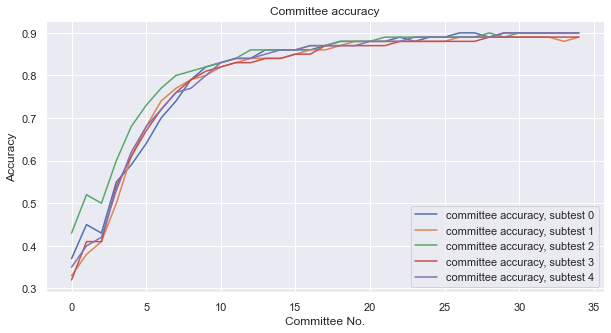

In [23]:
#plot commite_accuracy
plt.figure(figsize=(10,5))
plt.plot(accuracyCom1, label='committee accuracy, subtest 0')
plt.plot(accuracyCom2, label='committee accuracy, subtest 1')
plt.plot(accuracyCom3, label='committee accuracy, subtest 2')
plt.plot(accuracyCom4, label='committee accuracy, subtest 3')
plt.plot(accuracyCom5, label='committee accuracy, subtest 4')
plt.title('Committee accuracy')
plt.xlabel("Committee No.")
plt.ylabel("Accuracy")
plt.legend()

In [24]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: horse Predicted: horse


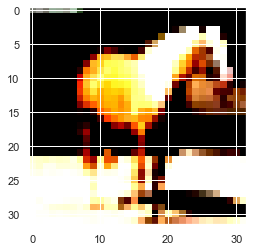

In [25]:
b = random.randint(0, len(test_dataset)-1)
img, label = test_dataset[b]
plt.imshow(img.permute(1, 2, 0))
print(f'Label: {train_dataset.classes[label]} Predicted: {predict_image(img, model)}')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

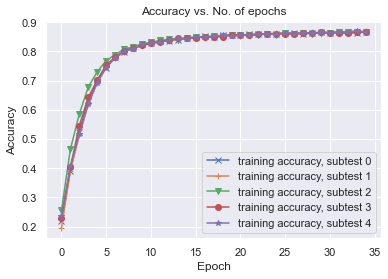

In [26]:
import itertools
marker = itertools.cycle(('x', '+', 'v', 'o', '*',''))
for cv_iter in range(5):
    plt.plot(acc_cv_list[cv_iter], label='training accuracy, subtest '+str(cv_iter),marker = next(marker))
#plot commite_accuracy
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of epochs')
#plt.savefig(result_folder+'training-accuracy-CV5.png')

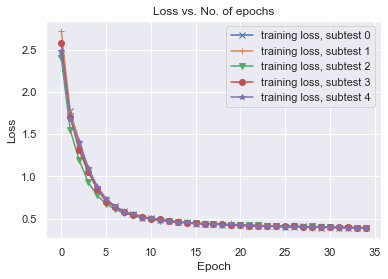

In [27]:
import itertools
marker = itertools.cycle(('x', '+', 'v', 'o', '*',''))
for cv_iter in range(5):
    plt.plot(loss_cv_list[cv_iter], label='training loss, subtest '+str(cv_iter),marker = next(marker))
#plt.plot(loss_cv_list[5], label='average training loss',marker = next(marker))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. No. of epochs')
plt.legend()
#plt.savefig(result_folder+'training-loss-CV5.png')

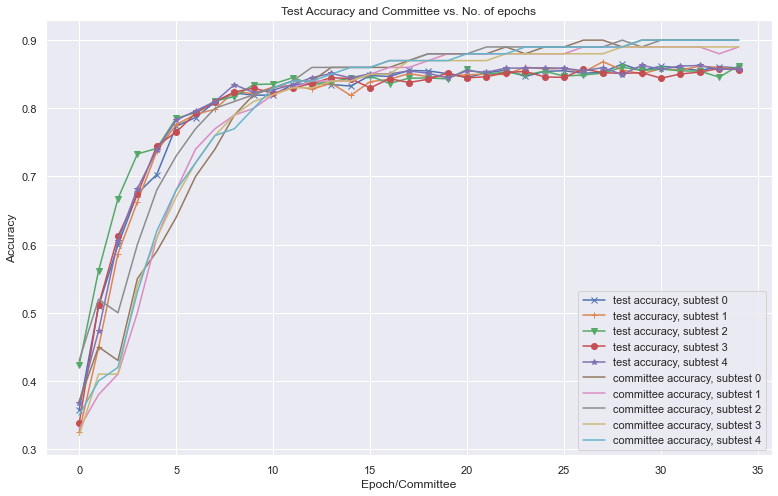

In [263]:
import itertools
marker = itertools.cycle(('x', '+', 'v', 'o', '*',''))
plt.figure(figsize=(13,8))
for cv_iter in range(5):
    plt.plot(tst_acc_cv_list[cv_iter], label='test accuracy, subtest '+str(cv_iter),marker = next(marker))
#plt.plot(tst_acc_cv_list[5], label='average test accuracy',marker = next(marker))
plt.plot(accuracyCom1, label='committee accuracy, subtest 0')
plt.plot(accuracyCom2, label='committee accuracy, subtest 1')
plt.plot(accuracyCom3, label='committee accuracy, subtest 2')
plt.plot(accuracyCom4, label='committee accuracy, subtest 3')
plt.plot(accuracyCom5, label='committee accuracy, subtest 4')    
plt.xlabel('Epoch/Committee')
plt.ylabel('Accuracy')
plt.title('Test and Committee accuracy vs. No. of epochs')
plt.legend()
#plt.savefig(result_folder+'training-test-accuracy-CV5.png')

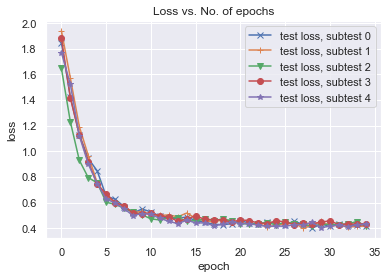

In [29]:
import itertools
marker = itertools.cycle(('x', '+', 'v', 'o', '*',''))
for cv_iter in range(5):
    plt.plot(tst_loss_cv_list[cv_iter], label='test loss, subtest '+str(cv_iter),marker = next(marker))
#plt.plot(tst_loss_cv_list[5], label='average test loss',marker = next(marker)) 
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')   
plt.legend()
#plt.savefig(result_folder+'training-test-loss-CV5.png')

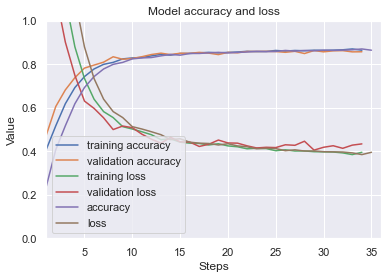

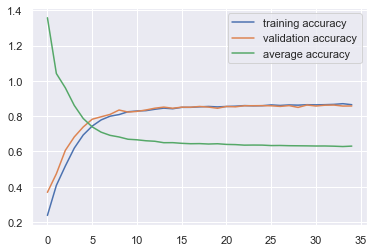

In [30]:
 #Save the model
#torch.save(net.state_dict(), 'conv_net_model.ckpt')

plt.plot(acc_list, label='training accuracy')
plt.plot(tst_acc_list, label='validation accuracy')
plt.legend()

plt.plot(loss_list, label='training loss')
plt.plot(tst_loss_list, label='validation loss')
plt.legend()

# Plot the model
ax = sns.lineplot(
    y=acc_list,
    x=range(1, len(acc_list) + 1),
    label='accuracy',
)
sns.lineplot(
    y=loss_list,
    x=range(1, len(loss_list) + 1),
    label='loss',
)
plt.ylim(0,1)
plt.xlim(1, len(loss_list) + 1)
plt.title('Model accuracy and loss')
ax.set(xlabel='Steps', ylabel='Value')
plt.show()

average=[]
for i in range(len(acc_list)):
    average.append((acc_list[i]+loss_list[i])/2)

plt.plot(acc_list, label='training accuracy')
plt.plot(tst_acc_list, label='validation accuracy')
plt.plot(average, label='average accuracy')
plt.legend()